## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [2]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

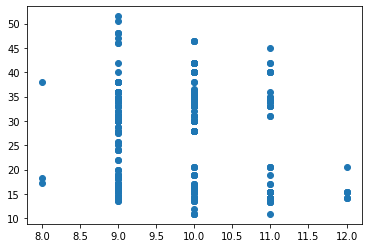

In [3]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

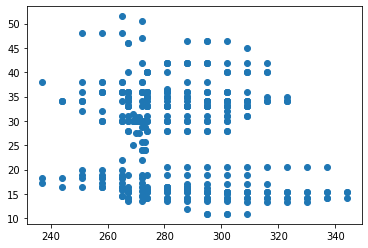

In [4]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

从 Scikit-learn 添加一个库以自动将所有字符串数据转换为数字

In [5]:
from sklearn.preprocessing import LabelEncoder

new_pumpkins.iloc[:, 0:-1] = new_pumpkins.iloc[:, 0:-1].apply(LabelEncoder().fit_transform)
new_pumpkins.head()

,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,1,5,3,1,0,5,3,13.636364
71,1,5,3,1,0,10,7,16.363636
72,2,11,3,1,0,10,7,16.363636
73,2,11,3,1,0,9,6,15.454545
74,2,12,3,1,0,5,3,13.636364


尝试在数据的两点之间找到良好的相关性，以构建良好的预测模型。

In [6]:
print(new_pumpkins['City'].corr(new_pumpkins['Price']))

0.32363971816089215


In [7]:
print(new_pumpkins['Package'].corr(new_pumpkins['Price']))

0.6061712937226045


对这些数据提出的一个很好的问题是：“我可以期望给定的南瓜包装的价格是多少？”
在构建模型之前，再对数据进行一次整理。删除任何空数据并再次检查数据的样子。

In [8]:
new_pumpkins.dropna(inplace=True)
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   DayOfYear   415 non-null    int64  
 2   Variety     415 non-null    int64  
 3   City        415 non-null    int64  
 4   Package     415 non-null    int64  
 5   Low Price   415 non-null    int64  
 6   High Price  415 non-null    int64  
 7   Price       415 non-null    float64
dtypes: float64(1), int64(7)
memory usage: 45.3 KB


然后，从这个最小集合创建一个新的 dataframe 并将其打印出来：

In [9]:
new_columns = ['Package', 'Price']
lin_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

lin_pumpkins

,Package,Price
70,0,13.636364
71,0,16.363636
72,0,16.363636
73,0,15.454545
74,0,13.636364
...,...,...
1738,2,30.000000
1739,2,28.750000
1740,2,25.750000
1741,2,24.000000


In [10]:
X = lin_pumpkins.values[:, :1]
y = lin_pumpkins.values[:, 1:2]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

accuracy_score = lin_reg.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.33153423279989847


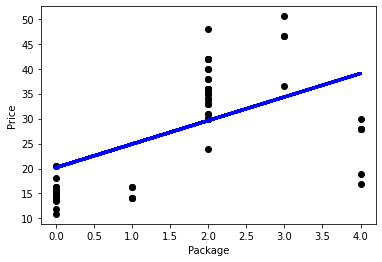

In [12]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, pred, color='blue', linewidth=3)

plt.xlabel('Package')
plt.ylabel('Price')

plt.show()

针对假设的品种测试模型：

In [13]:
lin_reg.predict( np.array([ [2.75] ]) )

array([[33.15655975]])

## 多项式回归

再看一下上图中品种与价格之间的关系。这个散点图看起来是否应该用一条直线来分析？也许不是。在这种情况下，你可以尝试多项式回归。
让我们重新创建一个填充了原始南瓜数据片段的 dataframe：

In [14]:
new_columns = ['Variety', 'Package', 'City', 'Month', 'Price']
poly_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

poly_pumpkins

,Month,Variety,City,Package,Price
70,1,3,1,0,13.636364
71,1,3,1,0,16.363636
72,2,3,1,0,16.363636
73,2,3,1,0,15.454545
74,2,3,1,0,13.636364
...,...,...,...,...,...
1738,1,1,9,2,30.000000
1739,1,1,9,2,28.750000
1740,1,1,9,2,25.750000
1741,1,1,9,2,24.000000


可视化 dataframe 中数据之间相关性的一种好方法是将其显示在“coolwarm”图表中：
使用 Background_gradient() 方法和 coolwarm 作为其参数值：

In [15]:
corr = poly_pumpkins.corr()
corr.style.background_gradient(cmap='coolwarm')

,Month,Variety,City,Package,Price
Month,1.000000,0.171330,-0.188728,-0.144847,-0.148783
Variety,0.171330,1.000000,-0.248441,-0.614855,-0.863479
City,-0.188728,-0.248441,1.000000,0.301604,0.323640
Package,-0.144847,-0.614855,0.301604,1.000000,0.606171
Price,-0.148783,-0.863479,0.323640,0.606171,1.000000


查看此图表，可以直观地看到 Package 和 Price 之间的良好相关性。
所以你应该能够创建一个比上一个更好的模型。

### 创建管道
Scikit-learn 包含一个用于构建多项式回归模型的有用 API - make_pipeline API。 创建了一个“管道”，它是一个估计器链。在这种情况下，管道包括多项式特征或形成非线性路径的预测。
构建 X 和 y 列：

In [17]:
X=poly_pumpkins.iloc[:,3:4].values
y=poly_pumpkins.iloc[:,4:5].values


通过调用 make_pipeline() 方法创建管道：
创建了一个机器学习流水线，其中包括多项式特征转换器（PolynomialFeatures）和线性回归模型（LinearRegression）。
test_size=0.2表示将20%的数据分配给测试集，random_state=0确保每次运行代码时划分结果相同。
PolynomialFeatures(4)是一个用于生成多项式特征的类，它将原始特征转换为多项式特征。在这里，参数4表示生成的多项式特征的最高次数为4。
例如，如果我们有一个一维的原始特征X = [x1, x2, x3]，使用PolynomialFeatures(4)将生成以下多项式特征：
```python
X_poly = [[x1, x1^2, x1^3, x1^4],
          [x2, x2^2, x2^3, x2^4],
          [x3, x3^2, x3^3, x3^4]]
```
它将原始特征X的每个值进行幂运算，并生成对应的多项式特征。这样做的目的是引入更高次数的特征，以捕捉特征之间的非线性关系，从而提高模型的拟合能力。

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(np.array(X_train), y_train)

y_pred=pipeline.predict(X_test)

创建序列
此时，你需要使用_排序好的_数据创建一个新的 dataframe ，以便管道可以创建序列。
inplace用于指定是否在原始数据框上进行就地排序。如果inplace=True，则数据框将被修改为排序后的顺序；如果inplace=False（默认值），则返回排序后的数据框副本，而原始数据框不会改变。

### dataFrame对象和numpy数组
- DataFrame对象是pandas库的一部分
    - 它提供了更高级的数据结构，用于处理和分析结构化数据。它可以存储具有不同数据类型的列，并提供了丰富的功能和灵活性，例如标签索引、缺失值处理和数据整理等。DataFrame对象适用于处理表格形式的数据，类似于关系型数据库中的表。
    - DataFrame提供了丰富的数据操作和处理功能，如数据过滤、分组、合并、重塑等。它还支持SQL类似的操作和面向列的计算。
    ``` python
    import pandas as pd
    data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [20, 21, 19],
        'Grade': [85, 92, 78]}
    df = pd.DataFrame(data)
    ```

- NumPy数组是NumPy库的核心数据结构
    - 它提供了高性能的数值计算和数组操作功能。NumPy数组是一个多维数组对象，存储相同类型的数据。它的主要优势在于对大规模数据的高效处理和数值计算的支持。
    - NumPy数组提供了高效的数值计算功能，包括向量化操作、线性代数、傅里叶变换等。
    ``` python
    import numpy as np
    data = np.array([['Alice', 20, 85],
                 ['Bob', 21, 92],
                 ['Charlie', 19, 78]])
    ```

In [20]:
df = pd.DataFrame({'x': X_test[:,0], 'y': y_pred[:,0]})
df.sort_values(by='x',inplace = True)
points = pd.DataFrame(df).to_numpy()
points


array([[ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        , 15.82902893],
       [ 0.        ,

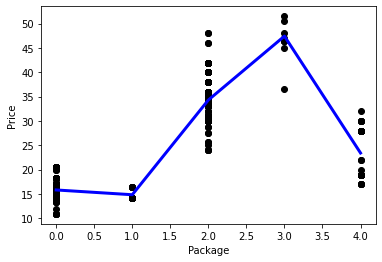

In [21]:
plt.plot(points[:, 0], points[:, 1],color="blue", linewidth=3)
plt.xlabel('Package')
plt.ylabel('Price')
plt.scatter(X,y, color="black")
plt.show()

你可以看到更适合你的数据的曲线。
让我们检查模型的准确性：

In [22]:
accuracy_score = pipeline.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.8537946517073784


做个预测

In [23]:
pipeline.predict( np.array([ [2.75] ]) )

array([[46.34509342]])

在本课中，我们学习了线性回归。还有其他重要的回归类型。了解 Stepwise、Ridge、Lasso 和 Elasticnet 技术。学习更多信息的好课程是 [斯坦福统计学习课程](https://online.stanford.edu/courses/sohs-ystatslearning-statistical-learning)